In [1]:
! python -m pip install -q towhee opencv-python pillow


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  16.8M      0  0:00:07  0:00:07 --:--:-- 18.3M


In [3]:
! wget https://github.com/milvus-io/milvus/releases/download/v2.2.10/milvus-standalone-docker-compose.yml -O docker-compose.yml
! docker-compose up -d
! python -m pip install -q pymilvus==2.2.11

zsh:1: command not found: wget
zsh:1: command not found: docker-compose

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

/Users/sloke/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [14]:
# Towhee parameters
MODEL = 'resnet50'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 10
DIM = 2048 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'reverse_image_search'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = 'reverse_image_search.csv'
QUERY_SRC = './test/*/*.JPEG'

In [15]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item
            
# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

2024-03-04 13:47:40,464 - 8106286144 - _builder.py-_builder:186 - INFO: Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
2024-03-04 13:47:40,654 - 8106286144 - connectionpool.py-connectionpool:546 - DEBUG: https://huggingface.co:443 "HEAD /timm/resnet50.a1_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2024-03-04 13:47:40,689 - 8106286144 - _hub.py-_hub:180 - INFO: [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-03-04 13:47:40,830 - 11088441344 - node.py-node:167 - INFO: Begin to run Node-_input
2024-03-04 13:47:40,831 - 11105267712 - node.py-node:167 - INFO: Begin to run Node-load_image-0
2024-03-04 13:47:40,831 - 11122094080 - node.py-node:167 - INFO: Begin to run Node-image-decode-1
2024-03-04 13:47:40,831 - 11088441344 - node.py-node:167 - INFO: Begin to run Node-image-embedding/timm-2
2024-03-04 13:47:40,831 - 11138920448 - node.py-node:167 - INFO: Begin to run

img_path,img,vec
./test/goldfish/n01443537_3883.JPEG,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

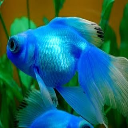

In [16]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')
DataCollection(p_display('./test/goldfish/*.JPEG')).show()

In [32]:
display_data = p_display('./test/goldfish/*.JPEG')

2024-03-04 14:22:59,914 - 11105267712 - node.py-node:167 - INFO: Begin to run Node-_input
2024-03-04 14:22:59,914 - 11341623296 - node.py-node:167 - INFO: Begin to run Node-load_image-0
2024-03-04 14:22:59,915 - 11122094080 - node.py-node:167 - INFO: Begin to run Node-image-decode-1
2024-03-04 14:22:59,915 - 11088441344 - node.py-node:167 - INFO: Begin to run Node-image-embedding/timm-2
2024-03-04 14:22:59,915 - 11138920448 - node.py-node:167 - INFO: Begin to run Node-_output


In [33]:
temp = display_data.get()

In [39]:
len(temp[2])

2048

In [40]:
type(display_data)

towhee.runtime.data_queue.DataQueue